In [1]:
!nvidia-smi

Fri Dec  5 08:51:20 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 570.133.07             Driver Version: 570.133.07     CUDA Version: 12.8     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 5070 Ti     On  |   00000000:01:00.0 Off |                  N/A |
| 31%   42C    P1             75W /  300W |    2227MiB /  16303MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [2]:
from IPython.display import clear_output

In [3]:
%pip install matplotlib
%pip install gdown
clear_output()
print("Packages downloaded.")

Packages downloaded.


In [4]:
!pip install gdown

In [ ]:
%%bash

WORKDIR=$(pwd)
DATASET_DIR="$WORKDIR/dataset"
DATASET_ZIP="$WORKDIR/dataset.zip"

if [ -d "$DATASET_DIR" ]; then
    echo "📁 Folder dataset sudah ada. Skip download & unzip."

elif [ -f "$DATASET_ZIP" ]; then
    echo "🗂️ ZIP ditemukan tanpa folder. Sedang di-unzip..."
    unzip -q "$DATASET_ZIP" -d "$DATASET_DIR"
    rm "$DATASET_ZIP"
    echo "✅ Unzip selesai."

else
    echo "⬇️ Download dataset dari Google Drive..."
    curl -L \
      -H "Authorization: Bearer TOKEN_SAYA" \
      "https://www.googleapis.com/drive/v3/files/1kaKoOooBB-r-TVsSIl_HZV6whnx7OFr8?alt=media" \
      -o "$DATASET_ZIP"

    echo "🛠️ Unzip dataset..."
    unzip -q "$DATASET_ZIP" -d "$DATASET_DIR"
    rm "$DATASET_ZIP"
    echo "✅ Selesai download & unzip."
fi


📁 Folder dataset sudah ada. Skip download & unzip.


In [6]:
import sys
print("Kernel Python:", sys.executable)

# upgrade pip/tooling
!{sys.executable} -m pip install --upgrade pip setuptools wheel

# common data / vision libs
!{sys.executable} -m pip install pandas numpy matplotlib tqdm pillow opencv-python scikit-image scikit-learn scipy timm torchmetrics transformers accelerate tokenizers evaluate 

Kernel Python: /venv/main/bin/python


## Import Dependencies

In [7]:
import numpy
import scipy
print(f"Numpy version: {numpy.__version__}")
print(f"Scipy version: {scipy.__version__}")

Numpy version: 2.1.2
Scipy version: 1.16.3


In [8]:
import os
import warnings
warnings.filterwarnings('ignore')
from glob import glob
from tqdm import tqdm
import time

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

import cv2
from PIL import Image

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as T
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms

In [9]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
ROOT_INP = "/workspace/dataset"
WORKDIR = "/workspace"
NUM_CLASSES = 11

print("DEVICE:", DEVICE)

DEVICE: cuda


## Dataset Loader

In [10]:
import glob
def get_sorted_paths(folder_path):
    files = sorted(glob.glob(os.path.join(folder_path, "*"))) 
    return files

train_image_paths = get_sorted_paths(ROOT_INP+'/train/train-org-img')
train_mask_paths = get_sorted_paths(ROOT_INP+'/train/train-label-img')

val_image_paths = get_sorted_paths(ROOT_INP+'/val/val-org-img')
val_mask_paths = get_sorted_paths(ROOT_INP+'/val/val-label-img')

test_image_paths = get_sorted_paths(ROOT_INP+'/test/test-org-img')
test_mask_paths = get_sorted_paths(ROOT_INP+'/test/test-label-img')

In [11]:
class RescueNetDataset(Dataset):
    def __init__(self, image_path, mask_path, transform=None, image_size=(512, 512)):
        self.image_path = image_path
        self.mask_path = mask_path
        self.transform = transform
        self.image_size = image_size

    def __len__(self):
        return len(self.image_path)

    def __getitem__(self, idx):
        image = Image.open(self.image_path[idx]).convert('RGB')
        mask = Image.open(self.mask_path[idx]).convert('L')

        if self.transform:
            image = self.transform(image)

        mask = mask.resize(self.image_size, Image.NEAREST)
        mask = np.array(mask, dtype=np.int64)
        # mask = np.clip(mask, 0, 9)
        mask = torch.from_numpy(mask).long()

        return image, mask

## Dataset Prep

In [12]:
train_test_transform = transforms.Compose([
    transforms.Resize((512, 512)),
    transforms.ToTensor(),
])

train_dataset = RescueNetDataset(train_image_paths, train_mask_paths, transform=train_test_transform)
val_dataset = RescueNetDataset(val_image_paths, val_mask_paths, transform=train_test_transform)
test_dataset = RescueNetDataset(test_image_paths, test_mask_paths, transform=train_test_transform)

BATCH_SIZE = 8

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

## Modelling

In [13]:
import torch
import torch.nn as nn
import timm

class PSPNet(nn.Module):
    def __init__(self, num_classes=10, backbone_name="efficientnet_b3"):
        super().__init__()

        self.encoder = timm.create_model(backbone_name, pretrained=True, features_only=True)

        encoder_channels = self.encoder.feature_info.channels()
        bottleneck_dim = encoder_channels[-1]

        self.ppm = nn.ModuleList([
            nn.Sequential(
                nn.AdaptiveAvgPool2d(scale),
                nn.Conv2d(bottleneck_dim, 256, kernel_size=1),
                nn.ReLU(inplace=True)
            )
            for scale in [1, 2, 3, 6]
        ])

        self.final = nn.Sequential(
            nn.Conv2d(bottleneck_dim + 4 * 256, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Dropout2d(0.1),
            nn.Conv2d(512, num_classes, kernel_size=1)
        )

    def forward(self, x):
        feats = self.encoder(x)
        x = feats[-1]

        ppm_outs = [x]
        for pool in self.ppm:
            pooled = pool(x)
            pooled = nn.functional.interpolate(
                pooled, size=x.shape[2:], mode="bilinear", align_corners=False
            )
            ppm_outs.append(pooled)

        x = torch.cat(ppm_outs, dim=1)
        x = self.final(x)
        x = nn.functional.interpolate(x, scale_factor=8, mode="bilinear", align_corners=False)

        return x

## Train

In [14]:
print(f"Train Images: {len(train_image_paths)}, Train Masks: {len(train_mask_paths)}")
print(f"Val Images: {len(val_image_paths)}, Val Masks: {len(val_mask_paths)}")

Train Images: 3595, Train Masks: 3595
Val Images: 449, Val Masks: 449


In [15]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(f"DEVICE {device}")

NUM_CLASSES = 11  
model = PSPNet(num_classes=NUM_CLASSES).to(device)

encoder_params = list(model.encoder.parameters())
decoder_params = list(model.ppm.parameters()) + list(model.final.parameters())

optimizer = torch.optim.AdamW([
    {"params": encoder_params, "lr": 6e-4},
    {"params": decoder_params, "lr": 9e-3},
], weight_decay=1e-2)

class DiceLoss(nn.Module):
    def __init__(self, smooth=1.0):
        super().__init__()
        self.smooth = smooth

    def forward(self, logits, target):
        logits = torch.softmax(logits, dim=1)
        target_1hot = torch.nn.functional.one_hot(target, num_classes=logits.size(1)).permute(0,3,1,2)

        intersection = (logits * target_1hot).sum(dim=(2,3))
        union = logits.sum(dim=(2,3)) + target_1hot.sum(dim=(2,3))

        dice = (2 * intersection + self.smooth) / (union + self.smooth)
        return 1 - dice.mean()


ce_loss = nn.CrossEntropyLoss()
dice_loss = DiceLoss()

def total_loss_fn(pred, target):
    return ce_loss(pred, target.long()) + dice_loss(pred, target.long())

scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
    optimizer,
    T_max=100, 
    eta_min=1e-6
)

EPOCHS = 25
# PATIENCE = 8   

DEVICE cuda


model.safetensors:   0%|          | 0.00/49.3M [00:00<?, ?B/s]

Unexpected keys (bn2.num_batches_tracked, bn2.bias, bn2.running_mean, bn2.running_var, bn2.weight, classifier.bias, classifier.weight, conv_head.weight) found while loading pretrained weights. This may be expected if model is being adapted.


In [16]:
import torch
from tqdm.auto import tqdm
from torchmetrics import JaccardIndex

metric_val = JaccardIndex(
    task="multiclass",
    num_classes=NUM_CLASSES,
    average=None
).to(device)

history = {
    "train_loss": [],
    "val_loss": [],
    "val_miou": []
}

best_loss = float("inf")
# patience_counter = 0

for epoch in range(EPOCHS):

    model.train()
    train_loss = 0.0

    for images, masks in tqdm(train_loader, desc=f"Train Epoch {epoch+1}/{EPOCHS}"):

        images, masks = images.to(device), masks.to(device)
        optimizer.zero_grad()

        preds = model(images)

        preds = torch.nn.functional.interpolate(
                    preds, 
                    size=masks.shape[-2:], 
                    mode="bilinear", 
                    align_corners=False
                )

        loss = total_loss_fn(preds, masks)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    train_loss /= len(train_loader)
    
    print(f"🎯 Train Loss: {train_loss:.4f}")
    history["train_loss"].append(train_loss)

    model.eval()
    val_loss = 0.0
    metric_val.reset()

    with torch.no_grad():
        for images, masks in tqdm(val_loader, desc=f"Val Epoch {epoch+1}/{EPOCHS}"):

            images, masks = images.to(device), masks.to(device)

            preds = model(images)

            preds = torch.nn.functional.interpolate(
                        preds, 
                        size=masks.shape[-2:], 
                        mode="bilinear", 
                        align_corners=False
                    )
            loss = total_loss_fn(preds, masks)
            val_loss += loss.item()

            pred_mask = torch.argmax(preds, dim=1)
            metric_val.update(pred_mask, masks)

    val_loss /= len(val_loader)
    iou_val_per_class = metric_val.compute()
    mIoU_val = iou_val_per_class.mean().item()

    history["val_loss"].append(val_loss)
    history["val_miou"].append(mIoU_val)

    # scheduler.step()

    print("\n=============================")
    print(f"Epoch {epoch+1}/{EPOCHS}")
    print(f"Train Loss: {train_loss:.4f}")
    print(f"Val Loss: {val_loss:.4f} | Val mIoU: {mIoU_val:.4f}")
    print("=============================\n")

    if val_loss < best_loss:
        best_loss = val_loss
        torch.save(model.state_dict(), "best_model_pspnet.pth")
        print("Model disimpan (best so far).")
print("Training Selesai!")


Train Epoch 1/25:   0%|          | 0/450 [00:00<?, ?it/s]

🎯 Train Loss: 2.0013


Val Epoch 1/25:   0%|          | 0/57 [00:00<?, ?it/s]


Epoch 1/25
Train Loss: 2.0013
Val Loss: 1.2136 | Val mIoU: 0.4099

Model disimpan (best so far).


Train Epoch 2/25:   0%|          | 0/450 [00:00<?, ?it/s]

🎯 Train Loss: 1.1596


Val Epoch 2/25:   0%|          | 0/57 [00:00<?, ?it/s]


Epoch 2/25
Train Loss: 1.1596
Val Loss: 0.9705 | Val mIoU: 0.4674

Model disimpan (best so far).


Train Epoch 3/25:   0%|          | 0/450 [00:00<?, ?it/s]

🎯 Train Loss: 1.0897


Val Epoch 3/25:   0%|          | 0/57 [00:00<?, ?it/s]


Epoch 3/25
Train Loss: 1.0897
Val Loss: 0.9683 | Val mIoU: 0.4691

Model disimpan (best so far).


Train Epoch 4/25:   0%|          | 0/450 [00:00<?, ?it/s]

🎯 Train Loss: 1.0114


Val Epoch 4/25:   0%|          | 0/57 [00:00<?, ?it/s]


Epoch 4/25
Train Loss: 1.0114
Val Loss: 0.9771 | Val mIoU: 0.5020



Train Epoch 5/25:   0%|          | 0/450 [00:00<?, ?it/s]

🎯 Train Loss: 0.9435


Val Epoch 5/25:   0%|          | 0/57 [00:00<?, ?it/s]


Epoch 5/25
Train Loss: 0.9435
Val Loss: 0.9669 | Val mIoU: 0.4949

Model disimpan (best so far).


Train Epoch 6/25:   0%|          | 0/450 [00:00<?, ?it/s]

🎯 Train Loss: 1.0335


Val Epoch 6/25:   0%|          | 0/57 [00:00<?, ?it/s]


Epoch 6/25
Train Loss: 1.0335
Val Loss: 1.6643 | Val mIoU: 0.4262



Train Epoch 7/25:   0%|          | 0/450 [00:00<?, ?it/s]

🎯 Train Loss: 1.0459


Val Epoch 7/25:   0%|          | 0/57 [00:00<?, ?it/s]


Epoch 7/25
Train Loss: 1.0459
Val Loss: 0.9514 | Val mIoU: 0.5062

Model disimpan (best so far).


Train Epoch 8/25:   0%|          | 0/450 [00:00<?, ?it/s]

🎯 Train Loss: 1.0365


Val Epoch 8/25:   0%|          | 0/57 [00:00<?, ?it/s]


Epoch 8/25
Train Loss: 1.0365
Val Loss: 0.9803 | Val mIoU: 0.4958



Train Epoch 9/25:   0%|          | 0/450 [00:00<?, ?it/s]

🎯 Train Loss: 0.9258


Val Epoch 9/25:   0%|          | 0/57 [00:00<?, ?it/s]


Epoch 9/25
Train Loss: 0.9258
Val Loss: 0.9707 | Val mIoU: 0.4870



Train Epoch 10/25:   0%|          | 0/450 [00:00<?, ?it/s]

🎯 Train Loss: 0.8359


Val Epoch 10/25:   0%|          | 0/57 [00:00<?, ?it/s]


Epoch 10/25
Train Loss: 0.8359
Val Loss: 0.8691 | Val mIoU: 0.5072

Model disimpan (best so far).


Train Epoch 11/25:   0%|          | 0/450 [00:00<?, ?it/s]

🎯 Train Loss: 0.9124


Val Epoch 11/25:   0%|          | 0/57 [00:00<?, ?it/s]


Epoch 11/25
Train Loss: 0.9124
Val Loss: 1.0230 | Val mIoU: 0.5031



Train Epoch 12/25:   0%|          | 0/450 [00:00<?, ?it/s]

🎯 Train Loss: 0.9207


Val Epoch 12/25:   0%|          | 0/57 [00:00<?, ?it/s]


Epoch 12/25
Train Loss: 0.9207
Val Loss: 0.9760 | Val mIoU: 0.4927



Train Epoch 13/25:   0%|          | 0/450 [00:00<?, ?it/s]

🎯 Train Loss: 0.8626


Val Epoch 13/25:   0%|          | 0/57 [00:00<?, ?it/s]


Epoch 13/25
Train Loss: 0.8626
Val Loss: 2.9800 | Val mIoU: 0.5235



Train Epoch 14/25:   0%|          | 0/450 [00:00<?, ?it/s]

🎯 Train Loss: 0.8994


Val Epoch 14/25:   0%|          | 0/57 [00:00<?, ?it/s]


Epoch 14/25
Train Loss: 0.8994
Val Loss: 0.8701 | Val mIoU: 0.5272



Train Epoch 15/25:   0%|          | 0/450 [00:00<?, ?it/s]

🎯 Train Loss: 0.8141


Val Epoch 15/25:   0%|          | 0/57 [00:00<?, ?it/s]


Epoch 15/25
Train Loss: 0.8141
Val Loss: 0.9199 | Val mIoU: 0.5103



Train Epoch 16/25:   0%|          | 0/450 [00:00<?, ?it/s]

🎯 Train Loss: 0.7708


Val Epoch 16/25:   0%|          | 0/57 [00:00<?, ?it/s]


Epoch 16/25
Train Loss: 0.7708
Val Loss: 0.9232 | Val mIoU: 0.5035



Train Epoch 17/25:   0%|          | 0/450 [00:00<?, ?it/s]

🎯 Train Loss: 0.8511


Val Epoch 17/25:   0%|          | 0/57 [00:00<?, ?it/s]


Epoch 17/25
Train Loss: 0.8511
Val Loss: 0.9060 | Val mIoU: 0.5322



Train Epoch 18/25:   0%|          | 0/450 [00:00<?, ?it/s]

🎯 Train Loss: 1.0142


Val Epoch 18/25:   0%|          | 0/57 [00:00<?, ?it/s]


Epoch 18/25
Train Loss: 1.0142
Val Loss: 2.2890 | Val mIoU: 0.2673



Train Epoch 19/25:   0%|          | 0/450 [00:00<?, ?it/s]

🎯 Train Loss: 1.2317


Val Epoch 19/25:   0%|          | 0/57 [00:00<?, ?it/s]


Epoch 19/25
Train Loss: 1.2317
Val Loss: 2.5049 | Val mIoU: 0.4363



Train Epoch 20/25:   0%|          | 0/450 [00:00<?, ?it/s]

🎯 Train Loss: 0.9711


Val Epoch 20/25:   0%|          | 0/57 [00:00<?, ?it/s]


Epoch 20/25
Train Loss: 0.9711
Val Loss: 39.0359 | Val mIoU: 0.4768



Train Epoch 21/25:   0%|          | 0/450 [00:00<?, ?it/s]

🎯 Train Loss: 1.0156


Val Epoch 21/25:   0%|          | 0/57 [00:00<?, ?it/s]


Epoch 21/25
Train Loss: 1.0156
Val Loss: 6.3991 | Val mIoU: 0.2301



Train Epoch 22/25:   0%|          | 0/450 [00:00<?, ?it/s]

🎯 Train Loss: 1.2559


Val Epoch 22/25:   0%|          | 0/57 [00:00<?, ?it/s]


Epoch 22/25
Train Loss: 1.2559
Val Loss: 4.6029 | Val mIoU: 0.3936



Train Epoch 23/25:   0%|          | 0/450 [00:00<?, ?it/s]

🎯 Train Loss: 1.0056


Val Epoch 23/25:   0%|          | 0/57 [00:00<?, ?it/s]


Epoch 23/25
Train Loss: 1.0056
Val Loss: 1.5105 | Val mIoU: 0.4134



Train Epoch 24/25:   0%|          | 0/450 [00:00<?, ?it/s]

🎯 Train Loss: 0.8929


Val Epoch 24/25:   0%|          | 0/57 [00:00<?, ?it/s]


Epoch 24/25
Train Loss: 0.8929
Val Loss: 4.3572 | Val mIoU: 0.4564



Train Epoch 25/25:   0%|          | 0/450 [00:00<?, ?it/s]

🎯 Train Loss: 1.1472


Val Epoch 25/25:   0%|          | 0/57 [00:00<?, ?it/s]


Epoch 25/25
Train Loss: 1.1472
Val Loss: 1.4585 | Val mIoU: 0.4273

Training Selesai!


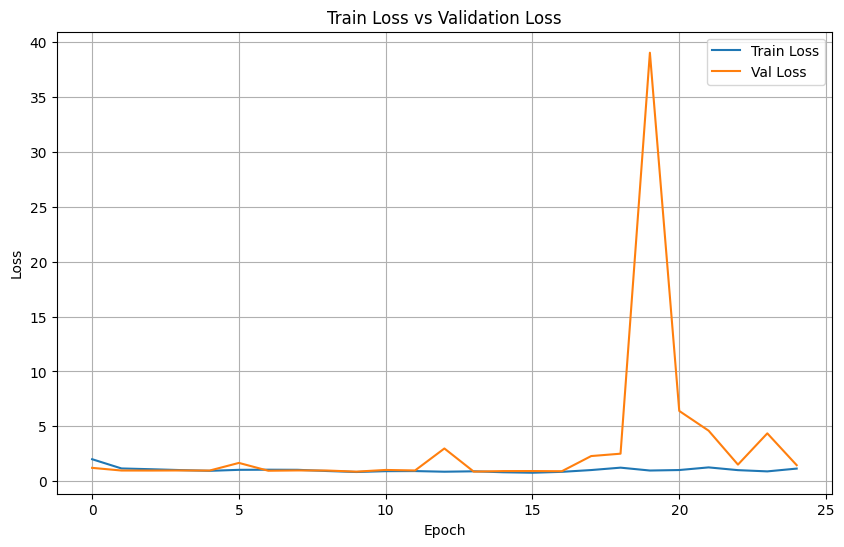

In [17]:
import matplotlib.pyplot as plt

# Plot Train Loss vs Val Loss
plt.figure(figsize=(10, 6))
plt.plot(history["train_loss"], label="Train Loss")
plt.plot(history["val_loss"], label="Val Loss")
plt.title("Train Loss vs Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()

In [18]:
import json

output_path = WORKDIR+"/history_pspnet.json"

with open(output_path, "w") as f:
    json.dump(history, f, indent=4)

print("File saved to:", output_path)

File saved to: /workspace/history_pspnet.json


## Testing

In [19]:
import torch
from tqdm.auto import tqdm
from torchmetrics import JaccardIndex  

def test_model(model, test_loader, device):
    metric = JaccardIndex(
        task="multiclass", 
        num_classes=11, 
        ignore_index=255,
        average="none" 
    ).to(device)

    model.to(device)
    
    model.eval()
    test_loss = 0.0
    print("Mulai Testing (menggunakan JaccardIndex)...")
    
    with torch.no_grad():
        for images, masks in tqdm(test_loader, desc="Testing"):
            
            images, masks = images.to(device), masks.to(device)

            preds = model(images)

            preds = torch.nn.functional.interpolate(
                        preds, 
                        size=masks.shape[-2:], 
                        mode="bilinear", 
                        align_corners=False
                    )
            loss = total_loss_fn(preds, masks)
            test_loss += loss.item()

            pred_mask = torch.argmax(preds, dim=1)
            metric.update(pred_mask, masks)
    
    iou_per_class = metric.compute()
    
    mIoU = iou_per_class.mean().item()
    
    print("\n=== HASIL TESTING ===")
    print(f"Mean IoU (mIoU): {mIoU:.4f}")
    print("-" * 30)
    
    class_names = [
        "Background", "Water", "Building No Damage", "Building Minor Damage", 
        "Building Major Damage", "Building Total Destruction", "Road-Clear", 
        "Road-Blocked", "Vehicle", "Tree", "Pool"
    ]
    
    for i, iou in enumerate(iou_per_class):
        name = class_names[i] if i < len(class_names) else f"Class {i}"
        print(f"{name:25s}: {iou.item():.4f}")
        
    metric.reset()
    return mIoU, iou_per_class

In [20]:
import torch
import torch.nn as nn

class_names = [
    "Background", "Water", "Building No Damage", "Building Minor Damage", 
    "Building Major Damage", "Building Total Destruction", "Road-Clear", 
    "Road-Blocked", "Vehicle", "Tree", "Pool"
]
num_classes = len(class_names)  

model = PSPNet(num_classes=num_classes).to(device)

ckpt_path = WORKDIR + "/best_model_pspnet.pth"
ckpt = torch.load(ckpt_path, map_location="cpu")

if isinstance(ckpt, dict):
    if "model_state_dict" in ckpt:
        ckpt_state = ckpt["model_state_dict"]
    elif "state_dict" in ckpt:
        ckpt_state = ckpt["state_dict"]
    elif "model" in ckpt:
        ckpt_state = ckpt["model"]
    else:
        ckpt_state = ckpt
else:
    ckpt_state = ckpt

try:
    model.load_state_dict(ckpt_state)
    print("Loaded checkpoint with strict=True (perfect match).")
except RuntimeError as e:
    print("Strict load failed (mismatch). Error:", e)
    model_state = model.state_dict()
    compatible = {}
    mismatched = []
    for k, v in ckpt_state.items():
        if k in model_state:
            if v.shape == model_state[k].shape:
                compatible[k] = v
            else:
                mismatched.append((k, v.shape, model_state[k].shape))
    print(f"Compatible keys: {len(compatible)} / {len(model_state)}")
    if mismatched:
        print("Mismatched keys (name, ckpt_shape, model_shape):")
        for item in mismatched:
            print(" ", item)

    model_state.update(compatible)
    model.load_state_dict(model_state)
    print("Loaded compatible weights; mismatched layers left as randomly initialized.")

Unexpected keys (bn2.num_batches_tracked, bn2.bias, bn2.running_mean, bn2.running_var, bn2.weight, classifier.bias, classifier.weight, conv_head.weight) found while loading pretrained weights. This may be expected if model is being adapted.


Loaded checkpoint with strict=True (perfect match).


In [21]:
test_mIoU, test_iou_per_class = test_model(model, test_loader, device)


print(f"===================== Hasil Testing mIoU {test_mIoU} ========================\n")
print(f"===================== Hasil Testing mIoU {test_mIoU} ========================\n")
print(f"===================== Hasil Testing mIoU {test_mIoU} ========================\n")
print(f"===================== Hasil Testing mIoU {test_mIoU} ========================\n")
print(f"===================== Hasil Testing mIoU {test_mIoU} ========================\n\n\n")
print(f"===================== IoU Per Class ========================")
for i, iou in enumerate(test_iou_per_class):
        name = class_names[i] if i < len(class_names) else f"Class {i}"
        print(f"{name:25s}: {iou.item():.4f}")


Mulai Testing (menggunakan JaccardIndex)...


Testing:   0%|          | 0/57 [00:00<?, ?it/s]


=== HASIL TESTING ===
Mean IoU (mIoU): 0.4882
------------------------------
Background               : 0.7639
Water                    : 0.7341
Building No Damage       : 0.4880
Building Minor Damage    : 0.3204
Building Major Damage    : 0.4518
Building Total Destruction: 0.4700
Road-Clear               : 0.2589
Road-Blocked             : 0.6157
Vehicle                  : 0.1296
Tree                     : 0.7577
Pool                     : 0.3797
===================== Hasil Testing mIoU 0.4881654381752014 ========================

===================== Hasil Testing mIoU 0.4881654381752014 ========================

===================== Hasil Testing mIoU 0.4881654381752014 ========================

===================== Hasil Testing mIoU 0.4881654381752014 ========================

===================== Hasil Testing mIoU 0.4881654381752014 ========================



===================== IoU Per Class ========================
Background               : 0.7639
Water               

## Visualisasi Sample Test

In [22]:
# import matplotlib.pyplot as plt
# import numpy as np
# import torch
# import os
# from matplotlib.patches import Patch

# CLASS_NAMES = [
#     "Background",               
#     "Water",                    
#     "Building No Damage",       
#     "Building Minor Damage",    
#     "Building Major Damage",    
#     "Building Total Destruction",
#     "Road-Clear",               
#     "Road-Blocked",             
#     "Vehicle",                  
#     "Tree",                     
#     "Pool"                      
# ]

# LABEL_COLORS = np.array([
#     [0, 0, 0],         # Background 
#     [30, 230, 255],    # Water 
#     [184, 115, 117],   # Building No Damage
#     [216, 255, 0],     # Building Minor Damage
#     [252, 199, 0],     # Building Major Damage
#     [255, 0, 0],       # Building Total Destruction
#     [140, 140, 140],   # Road-Clear
#     [151, 0, 255],     # Road-Blocked
#     [255, 0, 246],     # Vehicle 
#     [0, 255, 0],       # Tree
#     [244, 255, 0]      # Pool
# ])
# def decode_segmap(mask):
#     r = np.zeros_like(mask).astype(np.uint8)
#     g = np.zeros_like(mask).astype(np.uint8)
#     b = np.zeros_like(mask).astype(np.uint8)
    
#     for l in range(0, len(LABEL_COLORS)):
#         idx = mask == l
#         r[idx] = LABEL_COLORS[l, 0]
#         g[idx] = LABEL_COLORS[l, 1]
#         b[idx] = LABEL_COLORS[l, 2]
        
#     rgb = np.stack([r, g, b], axis=2)
#     return rgb

# def find_indices_by_filename(dataset, target_ids):
#     found_indices = []
#     for target in target_ids:
#         found = False
#         for idx, path in enumerate(dataset.image_path):
#             if str(target) in os.path.basename(path):
#                 found_indices.append(idx)
#                 found = True
#                 break
#         if not found:
#             return 
#     return found_indices

# def visualize_specific_images(model, dataset, target_ids, device, processor):
#     model.eval()
    
#     indices = find_indices_by_filename(dataset, target_ids)

#     num_samples = len(indices)
#     fig, axes = plt.subplots(num_samples, 3, figsize=(18, 6 * num_samples))
    
#     if num_samples == 1:
#         axes = axes.reshape(1, -1)

#     for row_idx, idx in enumerate(indices):
#         image, mask = dataset[idx] 
        
#         filename = os.path.basename(dataset.image_path[idx])
        
#         inputs = processor(
#             images=[image], 
#             return_tensors="pt",
#             do_resize=False, 
#             do_rescale=False
#         )
#         inputs = {k: v.to(device) for k, v in inputs.items()}
        
#         with torch.no_grad():
#             outputs = model(**inputs)
        
#         target_sizes = [(mask.shape[0], mask.shape[1])]
#         pred_map = processor.post_process_semantic_segmentation(
#             outputs, target_sizes=target_sizes
#         )[0] 
        
#         img_np = image.permute(1, 2, 0).numpy()
        
#         mask_rgb = decode_segmap(mask.numpy())
#         pred_rgb = decode_segmap(pred_map.cpu().numpy())
        
#         axes[row_idx, 0].imshow(img_np)
#         axes[row_idx, 0].set_title(f"ID: {filename}\nOriginal Image")
#         axes[row_idx, 0].axis("off")
        
#         axes[row_idx, 1].imshow(mask_rgb)
#         axes[row_idx, 1].set_title("Ground Truth")
#         axes[row_idx, 1].axis("off")
        
#         axes[row_idx, 2].imshow(pred_rgb)
#         axes[row_idx, 2].set_title("Mask2Former Prediction")
#         axes[row_idx, 2].axis("off")

#     handles = [Patch(color=LABEL_COLORS[i]/255.0, label=CLASS_NAMES[i]) for i in range(len(CLASS_NAMES))]
#     fig.legend(handles=handles, loc='lower center', ncol=6, bbox_to_anchor=(0.5, 0.0), fontsize=12)

#     plt.savefig('visualisasi_prediksi_rescuenet.png', bbox_inches='tight', dpi=300)
    
#     plt.tight_layout()
#     plt.subplots_adjust(bottom=0.08) 
#     plt.show()

# target_ids = ["10794", "10801", "10807"]

# visualize_specific_images(model, test_dataset, target_ids, device, processor)

In [23]:
# model.eval()
# import matplotlib.pyplot as plt

# test_imgs, test_masks = next(iter(test_loader))

# with torch.no_grad():
#     inputs = [{"image": test_imgs[0].to(cfg.MODEL.DEVICE), "height": 512, "width": 512}]
    
#     outputs = model(inputs)
    
#     pred_mask = outputs[0]["sem_seg"].argmax(dim=0).cpu().numpy()

# plt.figure(figsize=(10, 5))
# plt.subplot(1, 2, 1); plt.title("Prediction"); plt.imshow(pred_mask)
# plt.subplot(1, 2, 2); plt.title("Ground Truth"); plt.imshow(test_masks[0])
# plt.show()